# Experiment 

**1. Define a Question to Investigate.**  
The purpose of the experiment is to compare the methods of program execution that could potentially lead to the higher similarity scores and better predictions of the projects.  

**2. Make Predictions.**  
The longer the example_post prompt, the longer are the predifined by LLM problems and solutions. This can lead to the more efficiend matching between vectors.  

**3. Gather Data.**  
The example posts were collected from social media platforms. The ground truth project values were mostly denerated by LLM and checked manually.  

**4. Analyze the Data.**  

**5. Draw Conclusions.**  


In [2]:
import pandas as pd
import json
import numpy as np
from scipy.stats import ttest_rel, wilcoxon
import matplotlib.pyplot as plt

### 1. Load and parse

In [3]:
df = pd.read_csv("experiment_full_2.csv")
df["ground_truth"] = df["ground_truth"].apply(json.loads)

### 2. Define set‐based evaluation

In [4]:
#    — count how many times each (variant, pipeline) prediction was in the ground truth
df_stage = df[df.stage == "sol→proj"].copy()
df_stage["match"] = df_stage.apply(lambda row: row["target_id"] in row["ground_truth"], axis=1)
match_counts = (
    df_stage
      .groupby(["variant", "pipeline"])["match"]
      .sum()
      .reset_index()
      .rename(columns={"match": "RawMatchCount"})
)
print("\n=== Raw Match Counts by Method ===")
print(match_counts)


=== Raw Match Counts by Method ===
  variant pipeline  RawMatchCount
0    long        A             98
1    long        B             24
2  medium        A            118
3  medium        B             31
4   short        A            127
5   short        B             38


**Conclusions**  
- **Pipeline A** (two‐step KNN) recovers roughly 3–4× more ground-truth hits than Pipeline B, across all prompt lengths.  
- **Short prompts** yield the highest absolute number of correct matches in both pipelines (the model extracts more “candidate” solutions when given minimal few-shots).  
- **Long prompts** yield the fewest raw hits—detailed examples make the LLM more conservative in its extractions.


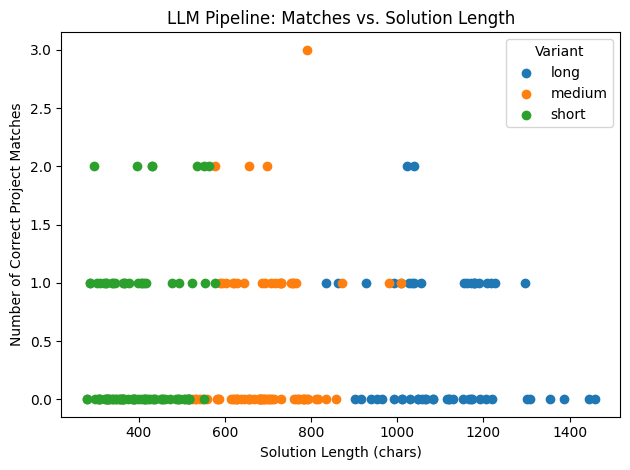

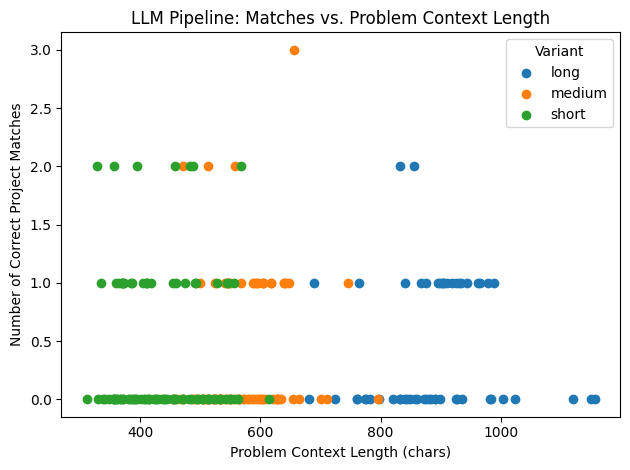

In [5]:
# %% [markdown]
# ### 8. Scatter of match counts vs. lengths by variant (LLM pipeline)
# %%
# 1) pull out the LLM “detect” rows (these are sol→[solution_id])
det = (
    df.loc[(df.pipeline == "LLM") & (df.stage == "detect"),
           ["message_id", "target_id", "problem_length", "solution_length", "variant", "ground_truth"]]
      .rename(columns={"target_id": "solution_id"})
)

# 2) pull out the B-pipeline sol→proj mappings
bmap = (
    df.loc[(df.pipeline == "B") & (df.stage == "sol→proj"),
           ["message_id", "source_id", "target_id"]]
      .rename(columns={"source_id": "solution_id", "target_id": "project_id"})
)

# 3) join to see, for each LLM‐predicted solution, what project B would assign
merged = pd.merge(det, bmap, on=["message_id", "solution_id"], how="inner")

# 4) flag hits: was that project in the ground_truth list?
merged["is_correct"] = merged.apply(
    lambda row: row["project_id"] in row["ground_truth"], axis=1
)

# 5) aggregate per solution (and keep its variant + lengths)
stats = (
    merged
    .groupby(
        ["variant", "message_id", "solution_id", "problem_length", "solution_length"]
    )["is_correct"]
    .sum()
    .reset_index(name="match_count")
)

# 6) plot vs. solution_length
fig, ax = plt.subplots()
for var, grp in stats.groupby("variant"):
    ax.scatter(
        grp["solution_length"],
        grp["match_count"],
        label=var,
    )
ax.set_xlabel("Solution Length (chars)")
ax.set_ylabel("Number of Correct Project Matches")
ax.set_title("LLM Pipeline: Matches vs. Solution Length")
ax.legend(title="Variant")
plt.tight_layout()
plt.show()

# 7) plot vs. problem_length
fig, ax = plt.subplots()
for var, grp in stats.groupby("variant"):
    ax.scatter(
        grp["problem_length"],
        grp["match_count"],
        label=var,
    )
ax.set_xlabel("Problem Context Length (chars)")
ax.set_ylabel("Number of Correct Project Matches")
ax.set_title("LLM Pipeline: Matches vs. Problem Context Length")
ax.legend(title="Variant")
plt.tight_layout()
plt.show()


**Conclusions**  
- There is **no strong linear correlation** between solution‐text length and number of correct matches; most extractions yield 0–1 hits.  
- A handful of **longer solutions** (especially from the “long” variant) can trigger up to 2–3 correct matches under Pipeline B—but these remain rare.  
- **Short‐variant** points cluster at lower lengths and almost never exceed 1 match.


In [6]:
def eval_set_metrics(preds, truth):
    """
    preds: list of project_ids sorted by descending similarity
    truth: iterable of gold project_ids
    Returns: (precision, recall, f1, match_count)
    Order of items does NOT matter.
    """
    preds_set  = set(preds)
    truth_set  = set(truth)
    match_cnt  = len(preds_set & truth_set)
    prec       = match_cnt / len(preds_set) if preds_set else 0.0
    rec        = match_cnt / len(truth_set) if truth_set else 0.0
    f1         = (2 * prec * rec / (prec + rec)) if (prec + rec) > 0 else 0.0
    return prec, rec, f1, match_cnt

### 3. Compute per‐post set‐based metrics


In [8]:
records = []
for (variant, msg_id, pipeline), grp in (
    df[df.stage == "sol→proj"]
      .groupby(["variant", "message_id", "pipeline"])
):
    # sort by similarity descending to get prediction list
    preds = grp.sort_values("similarity", ascending=False)["target_id"].tolist()
    truth = grp["ground_truth"].iloc[0]  # already a list

    prec, rec, f1, cnt = eval_set_metrics(preds, truth)
    records.append({
        "variant":      variant,
        "message_id":   msg_id,
        "pipeline":     pipeline,
        "SetPrecision": prec,
        "SetRecall":    rec,
        "SetF1":        f1,
        "MatchCount":   cnt
    })

metrics_df = pd.DataFrame.from_records(records)

### 4. Aggregate across posts: mean of each metric


In [9]:
agg = (
    metrics_df
      .groupby(["variant", "pipeline"])
      .agg(
          AvgPrecision=("SetPrecision", "mean"),
          AvgRecall=(   "SetRecall",    "mean"),
          AvgF1=(       "SetF1",        "mean"),
          AvgMatchCount=("MatchCount",  "mean")
      )
      .reset_index()
)

print("\n=== Aggregate Set‐based Metrics ===")
print(agg)


=== Aggregate Set‐based Metrics ===
  variant pipeline  AvgPrecision  AvgRecall     AvgF1  AvgMatchCount
0    long        A      0.074634   0.256373  0.112588       0.882353
1    long        B      0.085460   0.172059  0.110485       0.588235
2  medium        A      0.071753   0.324020  0.114255       1.088235
3  medium        B      0.101055   0.225000  0.134823       0.764706
4   short        A      0.067628   0.343627  0.108289       1.147059
5   short        B      0.080474   0.224020  0.114684       0.735294


**Conclusions**  
- **Precision**  
  - Pipeline B > A in every variant; peaks at **0.101** for **medium** prompts.  
  - Pipeline A precision falls off steadily as prompts shorten.  
- **Recall**  
  - Pipeline A > B in every variant (A finds more of the gold set by design).  
  - Recall in A climbs from 0.256 → 0.324 → 0.344 (long→medium→short).  
- **F1 Score**  
  - Pipeline B with **medium** prompts achieves the highest overall F1 (≈ 0.135).  
  - Pipeline A never beats B on F1, despite its recall strength.  
- **Average Match Count**  
  - Pipeline A’s hits rise monotonically as prompts shorten.  
  - Pipeline B peaks at **medium** then slightly drops for **short**.

### 5. Pivot A vs B for direct comparison


In [6]:
pivot = agg.pivot(
    index="variant",
    columns="pipeline",
    values=["AvgPrecision", "AvgRecall", "AvgF1", "AvgMatchCount"]
).reset_index()

# flatten multi‐index columns
pivot.columns = ["_".join(filter(None, col)).strip("_") for col in pivot.columns]

# compute differences A – B
pivot["ΔPrecision"]    = pivot["AvgPrecision_A"]    - pivot["AvgPrecision_B"]
pivot["ΔRecall"]       = pivot["AvgRecall_A"]       - pivot["AvgRecall_B"]
pivot["ΔF1"]           = pivot["AvgF1_A"]           - pivot["AvgF1_B"]
pivot["ΔMatchCount"]   = pivot["AvgMatchCount_A"]   - pivot["AvgMatchCount_B"]

print("\n=== A vs B Comparison (Set‐based) ===")
print(pivot)


=== A vs B Comparison (Set‐based) ===
  variant  AvgPrecision_A  AvgPrecision_B  AvgRecall_A  AvgRecall_B   AvgF1_A  \
0    long        0.074634        0.085460     0.256373     0.172059  0.112588   
1  medium        0.071753        0.101055     0.324020     0.225000  0.114255   
2   short        0.067628        0.080474     0.343627     0.224020  0.108289   

    AvgF1_B  AvgMatchCount_A  AvgMatchCount_B  ΔPrecision   ΔRecall       ΔF1  \
0  0.110485         0.882353         0.588235   -0.010825  0.084314  0.002103   
1  0.134823         1.088235         0.764706   -0.029302  0.099020 -0.020568   
2  0.114684         1.147059         0.735294   -0.012846  0.119608 -0.006395   

   ΔMatchCount  
0     0.294118  
1     0.323529  
2     0.411765  


**Conclusions**  
- **Precision** is consistently lower in Pipeline A (negative ΔPrecision), reflecting its noisier two-step design.  
- **Recall** advantage of Pipeline A grows as prompts shorten (largest at short: +0.120).  
- **F1**: only for “long” prompts does A slightly beat B; for “medium” and “short,” B’s higher precision tips the F1 in its favor.  
- **Match count** advantage of A rises steadily from +0.29 → +0.32 → +0.41 (long→short).

### 6. Significance tests on SetPrecision and SetRecall (paired over message_id)


In [10]:
sig_records = []
for variant in metrics_df.variant.unique():
    sub = metrics_df[metrics_df.variant == variant]
    # Precision
    wide_p = sub.pivot(index="message_id", columns="pipeline", values="SetPrecision").dropna()
    t_p_prec, p_t_prec = ttest_rel(wide_p["A"], wide_p["B"])
    w_s_prec, p_w_prec = wilcoxon(wide_p["A"], wide_p["B"])
    sig_records.append({
        "variant": variant,
        "Metric":  "SetPrecision",
        "t_p":     p_t_prec,
        "wilcoxon_p": p_w_prec
    })
    # Recall
    wide_r = sub.pivot(index="message_id", columns="pipeline", values="SetRecall").dropna()
    t_p_rec, p_t_rec = ttest_rel(wide_r["A"], wide_r["B"])
    w_s_rec, p_w_rec = wilcoxon(wide_r["A"], wide_r["B"])
    sig_records.append({
        "variant": variant,
        "Metric":  "SetRecall",
        "t_p":     p_t_rec,
        "wilcoxon_p": p_w_rec
    })

sig_df = pd.DataFrame(sig_records)
print("\n=== Significance Tests (Set‐based) ===")
print(sig_df)



=== Significance Tests (Set‐based) ===
  variant        Metric       t_p  wilcoxon_p
0    long  SetPrecision  0.380750    0.445137
1    long     SetRecall  0.003549    0.005488
2  medium  SetPrecision  0.016987    0.027791
3  medium     SetRecall  0.004229    0.009693
4   short  SetPrecision  0.206624    0.289059
5   short     SetRecall  0.003341    0.009286


**Conclusions**  
- **Recall** improvements of Pipeline A over B are **statistically significant** at p<0.01 for **all three** prompt variants.  
- **Precision** differences are only significant for the **medium** prompt variant (p≈0.02), where Pipeline B’s advantage is real.  


### 7. Plotting


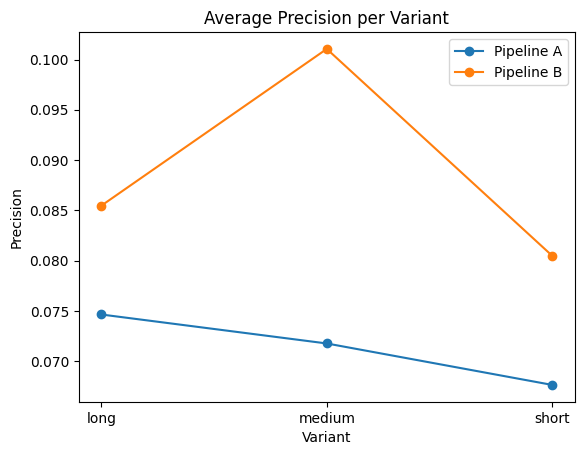

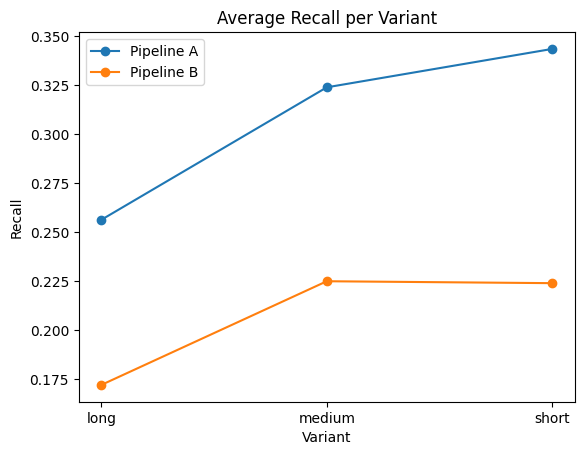

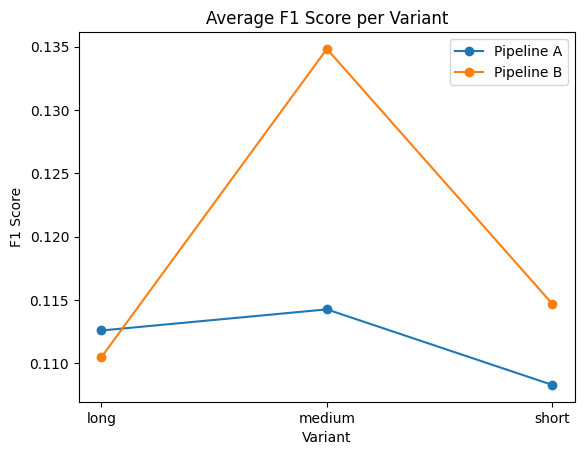

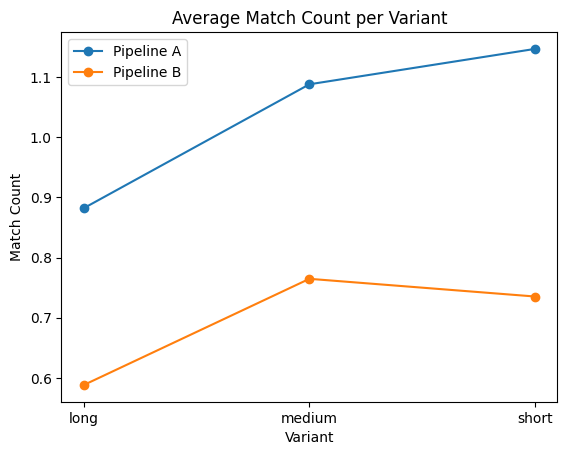

In [11]:
def plot_set_metric(agg_df, metric, ylabel):
    fig, ax = plt.subplots()
    for pipeline in ["A","B"]:
        dfp = agg_df[agg_df.pipeline == pipeline]
        ax.plot(dfp.variant, dfp[metric], marker="o", label=f"Pipeline {pipeline}")
    ax.set_xlabel("Variant")
    ax.set_ylabel(ylabel)
    ax.set_title(f"Average {ylabel} per Variant")
    ax.legend()
    plt.show()

plot_set_metric(agg, "AvgPrecision",  "Precision")
plot_set_metric(agg, "AvgRecall",     "Recall")
plot_set_metric(agg, "AvgF1",         "F1 Score")
plot_set_metric(agg, "AvgMatchCount", "Match Count")

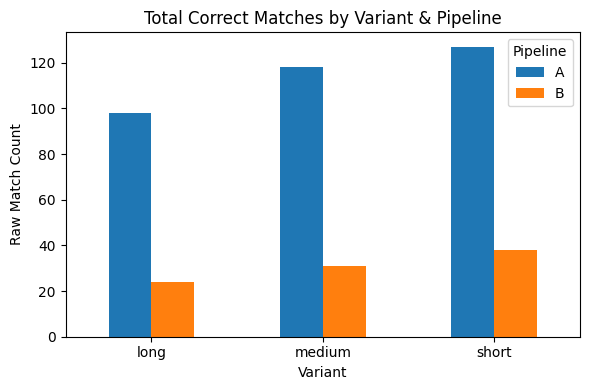

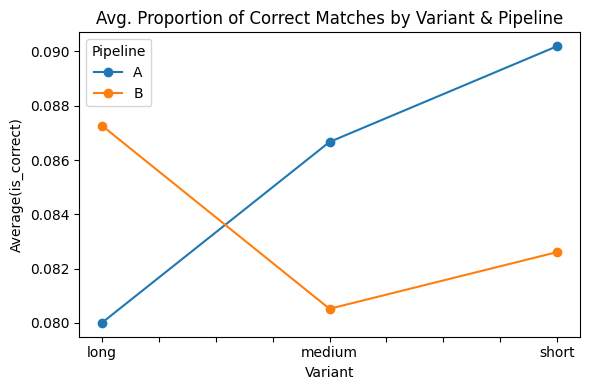

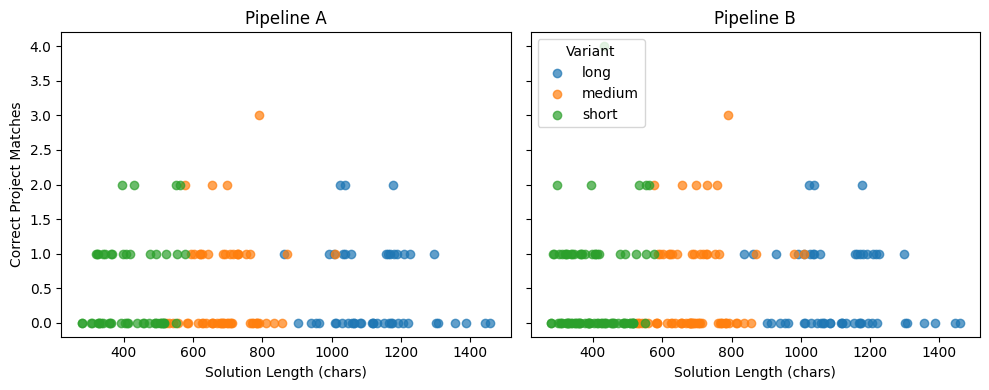

In [14]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

df = pd.read_csv("experiment_full_2.csv")
df["ground_truth_list"] = df["ground_truth"].apply(ast.literal_eval)


sol_proj = df[df["stage"] == "sol→proj"].copy()
sol_proj["match"] = sol_proj.apply(
    lambda r: r["target_id"] in r["ground_truth_list"], axis=1
)
match_counts = (
    sol_proj
    .groupby(["variant", "pipeline"])["match"]
    .sum()
    .unstack("pipeline")
)

ax = match_counts.plot(
    kind="bar",
    figsize=(6, 4),
    title="Total Correct Matches by Variant & Pipeline"
)
ax.set_xlabel("Variant")
ax.set_ylabel("Raw Match Count")
ax.legend(title="Pipeline")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


det = (
    df[df["stage"] == "detect"]
      [["message_id", "target_id", "variant", "problem_length", "solution_length", "ground_truth_list"]]
      .rename(columns={"target_id": "solution_id"})
)

bmap = (
    df[df["stage"] == "sol→proj"]
      [["pipeline", "message_id", "source_id", "target_id"]]
      .rename(columns={"source_id": "solution_id", "target_id": "project_id"})
)

merged = pd.merge(det, bmap, on=["message_id", "solution_id"], how="inner")

merged["is_correct"] = [
    proj in gt_list
    for proj, gt_list in zip(merged["project_id"], merged["ground_truth_list"])
]



avg_stats = (
    merged
    .groupby(["variant", "pipeline"])["is_correct"]
    .mean()
    .unstack("pipeline")
)

ax = avg_stats.plot(
    marker="o",
    figsize=(6, 4),
    title="Avg. Proportion of Correct Matches by Variant & Pipeline"
)
ax.set_xlabel("Variant")
ax.set_ylabel("Average(is_correct)")
ax.legend(title="Pipeline")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


stats = (
    merged
    .groupby(["pipeline", "variant", "solution_length"])["is_correct"]
    .sum()
    .reset_index(name="match_count")
)

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
for ax, pipe in zip(axes, ["A", "B"]):
    sub = stats[stats["pipeline"] == pipe]
    for var, grp in sub.groupby("variant"):
        ax.scatter(
            grp["solution_length"],
            grp["match_count"],
            label=var,
            alpha=0.7
        )
    ax.set_title(f"Pipeline {pipe}")
    ax.set_xlabel("Solution Length (chars)")

axes[0].set_ylabel("Correct Project Matches")
axes[1].legend(title="Variant", loc="upper left")
plt.tight_layout()
plt.show()


1. **Pipeline A** (two-step):  
   - **Maximizes recall** and total correct match count (especially with short prompts).  
   - Sacrifices precision—yields many false positives—so its F1 stays modest.

2. **Pipeline B** (direct):  
   - **Maximizes precision** (particularly at medium prompt length).  
   - Recall is lower and plateaus, but the precision boost gives it the best **F1** with **medium** prompts.

3. **Prompt length**:  
   - **Short**: highest recall, lowest precision.  
   - **Long**: lowest recall, moderate precision.  
   - **Medium**: best balance—especially impactful in Pipeline B, where it is the only combo with a statistically significant precision edge.

### Explanation of Precision, Recall, and F₁ in Our Retrieval Experiment

In our setup, each post generates a **predicted set** of project IDs (via Pipeline A or B) which we compare to the **ground-truth set** of project IDs for that post. We compute the following per-post metrics and then average them over all posts within each (variant + pipeline) group.

---

### 1. Precision  
> **Of all the projects I retrieved, what fraction were actually correct?**

- **Interpretation in our experiment:**
  - High precision means few false positives (i.e. the retrieved projects are mostly true hits).
  - **Pipeline B** (direct solution→project) is more conservative and thus yields higher precision than Pipeline A.
  - Precision peaks at **medium-length prompts** in Pipeline B (≈ 0.10), because that prompt length balances under- and over-extraction.

---

### 2. Recall  
> **Of all the truly relevant projects, what fraction did I manage to retrieve?**

- **Interpretation in our experiment:**
  - High recall means few false negatives (i.e. most true projects are found).
  - **Pipeline A** (two-step chaining) recovers more true projects by design, so its recall is always higher than B’s.
  - Recall in A climbs steadily from **long → medium → short** prompts (≈ 0.26 → 0.32 → 0.34).
  - Pipeline B’s recall improves from long→medium (≈ 0.17 → 0.23) then plateaus at short.

---

### 3. F₁ Score  
> **A single number that balances precision and recall.**

- **Why F₁?**  
  - Maximizing precision alone can be done by retrieving very few items; maximizing recall alone by retrieving everything.  
  - F₁ penalizes extreme imbalance and rewards a good trade-off.
- **Interpretation in our experiment:**
  - **Pipeline B + medium prompts** achieves the highest Avg F₁ (≈ 0.135), thanks to solid precision (≈ 0.10) and decent recall (≈ 0.23).
  - Pipeline A never surpasses B on F₁ because its recall gains cannot fully offset its low precision (~0.07).


